In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

import qiskit

import numpy as np



In [2]:
# Define the ticker symbols and the date range
tickers = ['AAPL', 'TSLA', 'MSFT', 'GOOGL']
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)

# Download historical data for the last 2 years
data = yf.download(tickers, start=start_date, end=end_date)
data.head()

/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_62243/4275999229.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  4 of 4 completed


Price            Close                                           High  \
Ticker            AAPL      GOOGL        MSFT        TSLA        AAPL   
Date                                                                    
2020-10-05  113.321625  73.633652  201.717697  141.893326  113.467534   
2020-10-06  110.072754  72.054031  197.431747  137.993332  112.951998   
2020-10-07  111.940361  72.457253  201.190338  141.766663  112.397540   
2020-10-08  111.833359  73.663429  201.909454  141.973328  113.224345   
2020-10-09  113.778786  75.005180  206.924118  144.666672  113.807966   

Price                                                 Low             \
Ticker          GOOGL        MSFT        TSLA        AAPL      GOOGL   
Date                                                                   
2020-10-05  73.726510  201.746461  144.546661  110.452110  72.504439   
2020-10-06  73.717553  201.525921  142.926666  109.187577  71.755591   
2020-10-07  72.945387  201.458808  143.300003  111.016275  71.170625   
2020-10-08  73.891850  202.494338  146.333328  111.463721  72.770585   
2020-10-09  75.074701  206.972062  144.863327  111.784712  73.840711   

Price                                     Open                         \
Ticker            MSFT        TSLA        AAPL      GOOGL        MSFT   
Date                                                                    
2020-10-05  198.457682  139.776672  110.802289  72.631560  198.687805   
2020-10-06  196.386631  135.350006  112.543451  73.269646  200.221933   
2020-10-07  198.208391  137.949997  111.492912  72.465693  198.534388   
2020-10-08  199.742514  141.766663  113.078436  72.770585  201.842330   
2020-10-09  202.532696  142.153336  112.134890  74.131703  202.532696   

Price                      Volume                                 
Ticker            TSLA       AAPL     GOOGL      MSFT       TSLA  
Date                                                              
2020-10-05  141.116669  106243800  21602000  21331600  134168400  
2020-10-06  141.263336  161498200  26096000  28554300  147438900  
2020-10-07  139.956665   96849000  36108000  25681100  129383100  
2020-10-08  146.146667   83477200  26076000  19925800  121263300  
2020-10-09  143.376663  100506900  32966000  26458000   86777100

In [3]:
def add_sma(data: pd.DataFrame, ticker: str, window: int) -> pd.DataFrame:
    """Add Simple Moving Average (SMA) for a given ticker and window."""
    data[(f"SMA_{window}", ticker)] = (
        data["Close"][ticker].rolling(window=window).mean()
    )
    return data

def add_ema(data: pd.DataFrame, ticker: str, window: int) -> pd.DataFrame:
    """Add Exponential Moving Average (EMA) for a given ticker and window."""
    data[(f"EMA_{window}", ticker)] = (
        data["Close"][ticker].ewm(span=window, adjust=False).mean()
    )
    return data

def add_macd(data: pd.DataFrame, ticker: str, short=12, long=26, signal=9) -> pd.DataFrame:
    """Add MACD and Signal line for a given ticker."""
    ema_short = data["Close"][ticker].ewm(span=short, adjust=False).mean()
    ema_long = data["Close"][ticker].ewm(span=long, adjust=False).mean()
    
    data[("MACD", ticker)] = ema_short - ema_long
    data[("Signal_Line", ticker)] = data[("MACD", ticker)].ewm(span=signal, adjust=False).mean()
    return data

def add_rsi(data: pd.DataFrame, ticker: str, window: int = 14) -> pd.DataFrame:
    """Add Relative Strength Index (RSI) for a given ticker."""
    close = data["Close"][ticker]
    delta = close.diff()
    
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    data[(f"RSI_{window}", ticker)] = rsi
    return data

def add_atr(data: pd.DataFrame, ticker: str, window: int = 14) -> None:
    """Add Average True Range (ATR) for a given ticker."""
    high = data["High"][ticker]
    low = data["Low"][ticker]
    close = data["Close"][ticker]
    prev_close = close.shift(1)

    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    data[(f"ATR_{window}",ticker)] = tr.rolling(window=window).mean()


In [4]:
def add_all_indicators(data: pd.DataFrame, tickers: list) -> pd.DataFrame:
    for t in tickers:
        # Short/long SMAs
        data = add_sma(data, t, 20)
        data = add_sma(data, t, 50)
        # Short/long EMAs
        data = add_ema(data, t, 20)
        data = add_ema(data, t, 50)
        # MACD
        data = add_macd(data, t)
        # RSI
        data = add_rsi(data, t, 14)
        # ATR
        add_atr(data, t, 14)

        data = data.sort_index(axis=1, level=0)
    return data

In [5]:
data = add_all_indicators(data, tickers)

data[50:100].head()

Price         ATR_14                                      Close             \
Ticker          AAPL     GOOGL      MSFT       TSLA        AAPL      GOOGL   
Date                                                                         
2020-12-15  2.840368  1.780510  3.212237  12.394762  124.605759  87.450844   
2020-12-16  2.856376  1.773522  3.428537  12.385714  124.537537  87.257660   
2020-12-17  2.877953  1.783027  3.467674  12.731904  125.404762  86.429382   
2020-12-18  2.780514  1.762382  3.418234  13.045476  123.417000  85.719780   
2020-12-21  2.811137  1.676120  3.607067  13.490237  124.946800  86.133926   

Price                                   EMA_20             ...      SMA_50  \
Ticker            MSFT        TSLA        AAPL      GOOGL  ...        MSFT   
Date                                                       ...               
2020-12-15  205.850815  211.083328  118.196699  87.709336  ...  205.233646   
2020-12-16  210.801666  207.589996  118.800589  87.666319  ...  205.501045   
2020-12-17  210.936279  218.633331  119.429557  87.548516  ...  205.695963   
2020-12-18  210.138351  231.666672  119.809314  87.374350  ...  205.860541   
2020-12-21  213.983688  216.619995  120.298598  87.256215  ...  206.001733   

Price                  Signal_Line                                    Volume  \
Ticker            TSLA        AAPL     GOOGL      MSFT       TSLA       AAPL   
Date                                                                           
2020-12-15  161.161266    1.556425  1.745225  0.215522  15.228144  157243700   
2020-12-16  162.553199    1.688049  1.596285  0.277243  15.206814   98208600   
2020-12-17  164.090533    1.842883  1.436022  0.393752  15.224312   94359800   
2020-12-18  165.884399    1.968234  1.262469  0.524866  15.438468  192541500   
2020-12-21  167.323466    2.088456  1.093414  0.718415  15.489412  121251600   

Price                                      
Ticker         GOOGL      MSFT       TSLA  
Date                                       
2020-12-15  21352000  27000600  135214500  
2020-12-16  24676000  35023300  126287400  
2020-12-17  34880000  32515800  168810300  
2020-12-18  85256000  63354900  666378600  
2020-12-21  33974000  37181900  174135900  

[5 rows x 52 columns]

In [6]:
for ticker in tickers:
    data[('Change', ticker)] = data[('Close', ticker)] - data[('Open', ticker)]
    data[('Change %', ticker)] = 200*data[('Change', ticker)]/(data[('Close', ticker)] + data[('Open', ticker)])
data.head()

Price      ATR_14                       Close                         \
Ticker       AAPL GOOGL MSFT TSLA        AAPL      GOOGL        MSFT   
Date                                                                   
2020-10-05    NaN   NaN  NaN  NaN  113.321625  73.633652  201.717697   
2020-10-06    NaN   NaN  NaN  NaN  110.072754  72.054031  197.431747   
2020-10-07    NaN   NaN  NaN  NaN  111.940361  72.457253  201.190338   
2020-10-08    NaN   NaN  NaN  NaN  111.833359  73.663429  201.909454   
2020-10-09    NaN   NaN  NaN  NaN  113.778786  75.005180  206.924118   

Price                       EMA_20             ...    Volume             \
Ticker            TSLA        AAPL      GOOGL  ...      MSFT       TSLA   
Date                                           ...                        
2020-10-05  141.893326  113.321625  73.633652  ...  21331600  134168400   
2020-10-06  137.993332  113.012208  73.483212  ...  28554300  147438900   
2020-10-07  141.766663  112.910128  73.385501  ...  25681100  129383100   
2020-10-08  141.973328  112.807578  73.411971  ...  19925800  121263300   
2020-10-09  144.666672  112.900074  73.563705  ...  26458000   86777100   

Price         Change  Change %    Change  Change %    Change  Change %  \
Ticker          AAPL      AAPL      TSLA      TSLA      MSFT      MSFT   
Date                                                                     
2020-10-05  2.519336  2.248163  0.776657  0.548855  3.029892  1.513412   
2020-10-06 -2.470697 -2.219692 -3.270004 -2.341935 -2.790186 -1.403324   
2020-10-07  0.447449  0.400522  1.809998  1.284947  2.655950  1.328890   
2020-10-08 -1.245078 -1.107170 -4.173340 -2.896946  0.067125  0.033251   
2020-10-09  1.643895  1.455330  1.290009  0.895704  4.391422  2.144999   

Price         Change  Change %  
Ticker         GOOGL     GOOGL  
Date                            
2020-10-05  1.002091  1.370239  
2020-10-06 -1.215615 -1.672975  
2020-10-07 -0.008441 -0.011649  
2020-10-08  0.892844  1.219449  
2020-10-09  0.873477  1.171376  

[5 rows x 60 columns]

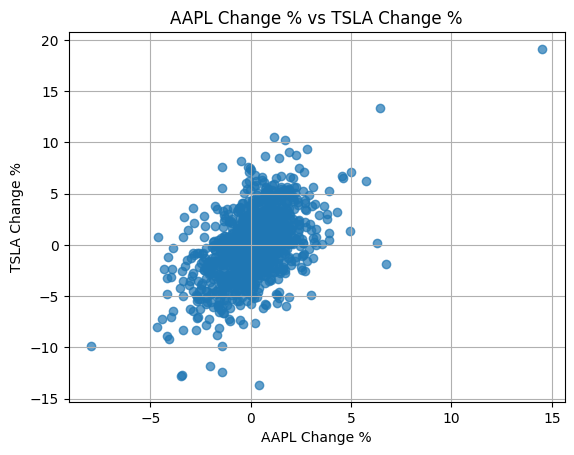

In [7]:
plt.scatter(data[('Change %', 'AAPL')], data[('Change %', 'TSLA')], alpha=0.7)
plt.xlabel('AAPL Change %')
plt.ylabel('TSLA Change %')
plt.title('AAPL Change % vs TSLA Change %')
plt.grid(True)
plt.show()

In [8]:

normalized_change = {}
for ticker in tickers:
    change_pct = data[('Change %', ticker)]
    norm = (change_pct - change_pct.min()) / (change_pct.max() - change_pct.min())
    normalized_change[ticker] = pd.Series(norm, index=data.index, name=ticker)
normalized_change


{'AAPL': Date
 2020-10-05    0.454143
 2020-10-06    0.255235
 2020-10-07    0.371886
 2020-10-08    0.304764
 2020-10-09    0.418846
                 ...   
 2025-09-26    0.377820
 2025-09-29    0.351781
 2025-09-30    0.350036
 2025-10-01    0.361207
 2025-10-02    0.363415
 Name: AAPL, Length: 1255, dtype: float64,
 'TSLA': Date
 2020-10-05    0.433482
 2020-10-06    0.345312
 2020-10-07    0.455933
 2020-10-08    0.328384
 2020-10-09    0.444061
                 ...   
 2025-09-26    0.501709
 2025-09-29    0.408907
 2025-09-30    0.438768
 2025-10-01    0.522500
 2025-10-02    0.184323
 Name: TSLA, Length: 1255, dtype: float64,
 'MSFT': Date
 2020-10-05    0.436655
 2020-10-06    0.241486
 2020-10-07    0.424308
 2020-10-08    0.337612
 2020-10-09    0.478917
                 ...   
 2025-09-26    0.353728
 2025-09-29    0.375818
 2025-09-30    0.396514
 2025-10-01    0.398905
 2025-10-02    0.310781
 Name: MSFT, Length: 1255, dtype: float64,
 'GOOGL': Date
 2020-10-05    0.53901

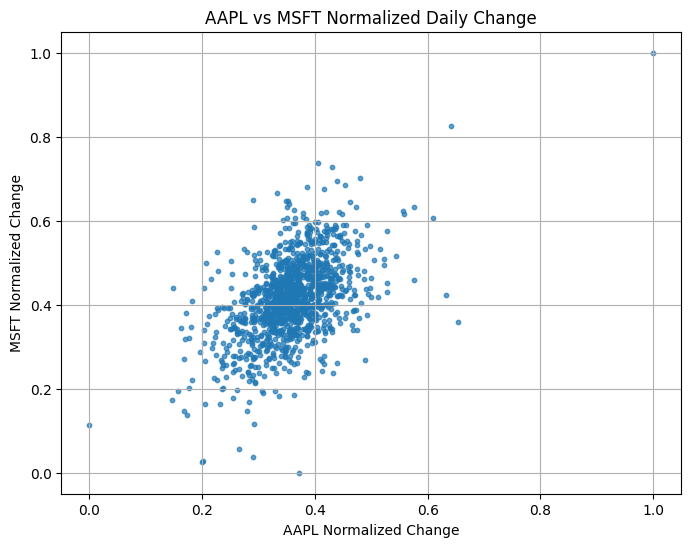

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(normalized_change['AAPL'], normalized_change['TSLA'], alpha=0.7, s=10)
plt.xlabel('AAPL Normalized Change')
plt.ylabel('MSFT Normalized Change')
plt.title('AAPL vs MSFT Normalized Daily Change')
plt.grid(True)
plt.show()

In [10]:
import qiskit
from qiskit.circuit.library import EfficientSU2

import numpy as np

In [11]:
num_stocks = len(tickers)
num_data_points = 12
num_qubits = num_stocks * int(np.ceil(num_data_points/4))

qc = qiskit.QuantumCircuit(num_qubits)



In [12]:
def data_loading_layer(qc, num_data_points, tickers):
    """
    Adds EfficientSU2 blocks to the quantum circuit for each ticker.
    
    Parameters:
        qc : QuantumCircuit
            The quantum circuit to append blocks to.
        num_data_points : int
            Number of data points (controls block size).
        tickers : list[str]
            List of ticker symbols (used as parameter prefixes).
    
    Returns:
        QuantumCircuit with appended EfficientSU2 blocks.
    """
    start = 0
    num_stocks = len(tickers)

    if num_data_points <= 2:
        group_sizes = num_stocks * [1]
    else:
        group_size = int(np.ceil(num_data_points / 4))
        group_sizes = num_stocks * [group_size]

    for ticker, size in zip(tickers, group_sizes):
        qubit_indices = list(range(start, start + size))
        su2_block = EfficientSU2(
            size,
            entanglement='circular',
            reps=1,
            insert_barriers=True,
            parameter_prefix=ticker  # prefix = ticker
        )
        qc.append(su2_block, qubit_indices)
        start += size

    return qc

In [13]:
data_loading_layer(qc,num_data_points,tickers)

/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_62243/1352235380.py:27: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  su2_block = EfficientSU2(


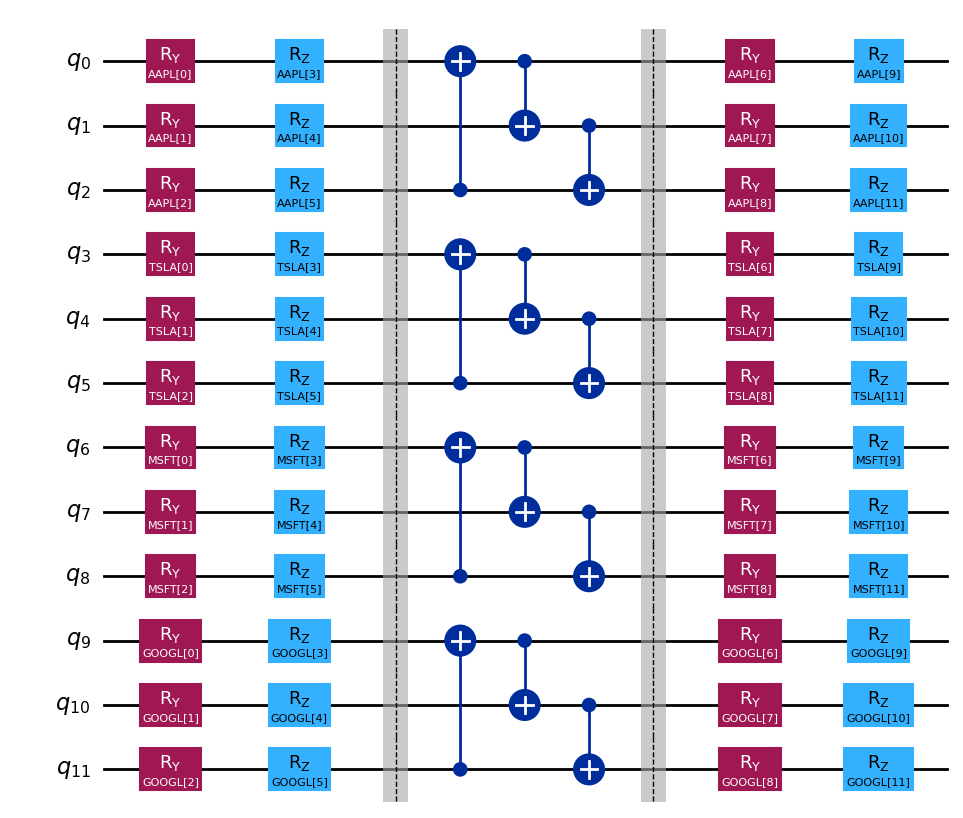

In [14]:

qc.decompose(reps=2).draw('mpl', fold=-1)

In [15]:
from qiskit.circuit.library import ZZFeatureMap

def parameterized_zz_layer(qc, num_data_points, tickers, reps=1):
    """
    Adds a ZZFeatureMap layer with reverse circular entanglement for multiple tickers.
    
    Each ticker is assigned a block of qubits. Within each block, reverse circular
    entanglement is applied, and the top qubit of one block is entangled with the 
    bottom qubit of the next block (circularly across tickers).
    
    Parameters:
        qc : QuantumCircuit
            The quantum circuit to append the layer to.
        num_data_points : int
            Number of data points (controls block size).
        tickers : list[str]
            List of ticker symbols (used as parameter prefixes).
        reps : int
            Number of repetitions of the ZZFeatureMap.
            
    Returns:
        QuantumCircuit with appended ZZFeatureMap layer.
    """
    start = 0
    num_stocks = len(tickers)

    # Determine qubit allocation per ticker
    if num_data_points <= 2:
        group_sizes = num_stocks * [1]
    else:
        group_size = int(np.ceil(num_data_points / 4))
        group_sizes = num_stocks * [group_size]

    block_indices = []
    for size in group_sizes:
        block_indices.append(list(range(start, start + size)))
        start += size

    # Apply ZZFeatureMap for each block
    for ticker, qubits in zip(tickers, block_indices):
        zz_block = ZZFeatureMap(
            feature_dimension=len(qubits),
            reps=reps,
            entanglement='reverse_linear',
            insert_barriers=True,
            parameter_prefix=f"{ticker}_zz"  # prefix = ticker
        )
        qc.compose(zz_block, qubits, inplace=True)

    # Connect top qubit of one block to bottom of next block (circular)
    for i in range(len(block_indices)):
        current_block = block_indices[i]
        next_block = block_indices[(i + 1) % num_stocks]
        qc.cz(current_block[-1], next_block[0])  # CZ between top and next bottom

    return qc

/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_62243/1423804949.py:41: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  zz_block = ZZFeatureMap(


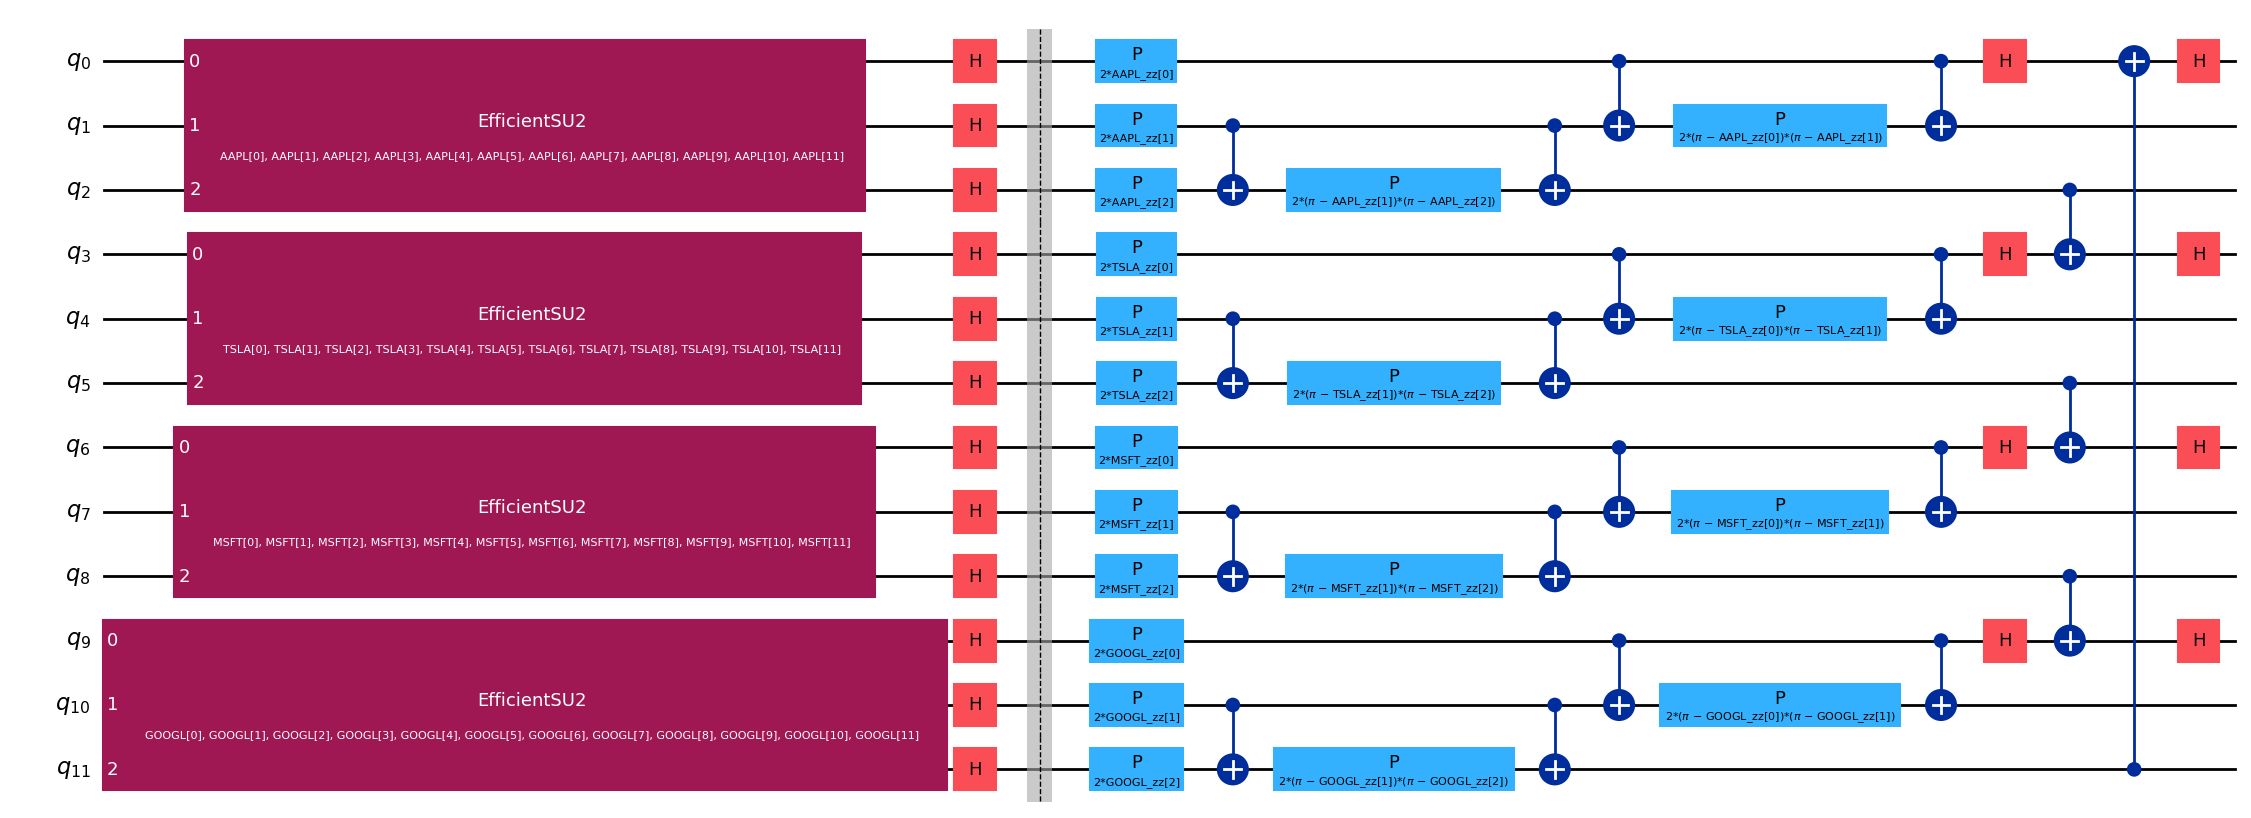

In [16]:
parameterized_zz_layer(qc, num_data_points, tickers, reps=1)

qc.decompose(reps=1).draw('mpl', fold=-1)


In [17]:
from qiskit import transpile, QuantumCircuit

def optimise_circuit_best(qc: QuantumCircuit, backend=None, trials: int = 5):
    """
    Transpile the quantum circuit multiple times and pick the one with the lowest 2-qubit depth.
    
    Parameters:
        qc : QuantumCircuit
            The quantum circuit to optimize.
        backend : Optional[BaseBackend]
            The backend to transpile for (None uses default simulator).
        trials : int
            Number of transpilation trials.
    
    Returns:
        best_qc : QuantumCircuit
            Transpiled circuit with lowest 2-qubit gate depth.
        best_2q_depth : int
            Depth of 2-qubit gates of the best circuit.
    """
    best_qc = None
    best_2q_depth = float('inf')

    for _ in range(trials):
        transpiled = transpile(qc, backend=backend, optimization_level=3)

        # Filter 2-qubit gates using a lambda
        two_qubit_gates = list(filter(lambda inst: inst[0].num_qubits == 2, transpiled.data))
        
        # Create a temporary circuit with only 2-qubit gates to compute depth
        temp_qc = QuantumCircuit(transpiled.num_qubits)
        for inst, qargs, cargs in two_qubit_gates:
            temp_qc.append(inst, qargs, cargs)
        
        two_q_depth = temp_qc.depth()

        print(f"Trial 2Q Depth: {two_q_depth}")
        if two_q_depth < best_2q_depth:
            best_2q_depth = two_q_depth
            best_qc = transpiled

    return best_qc, best_2q_depth

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)

print(f"{backend}")

management.get:WARNING:2025-10-03 00:19:33,939: Loading default saved account


<IBMBackend('ibm_torino')>


/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_62243/3720860525.py:28: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  two_qubit_gates = list(filter(lambda inst: inst[0].num_qubits == 2, transpiled.data))
/var/folders/0w/5lj7j7_12px_l21vwj96tgr80000gn/T/ipykernel_62243/3720860525.py:32: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in two_qubit_gates:


Trial 2Q Depth: 17
Trial 2Q Depth: 18
Trial 2Q Depth: 21
Trial 2Q Depth: 14
Trial 2Q Depth: 27
Trial 2Q Depth: 20
Trial 2Q Depth: 18
Trial 2Q Depth: 17
Trial 2Q Depth: 12
Trial 2Q Depth: 23
56
12


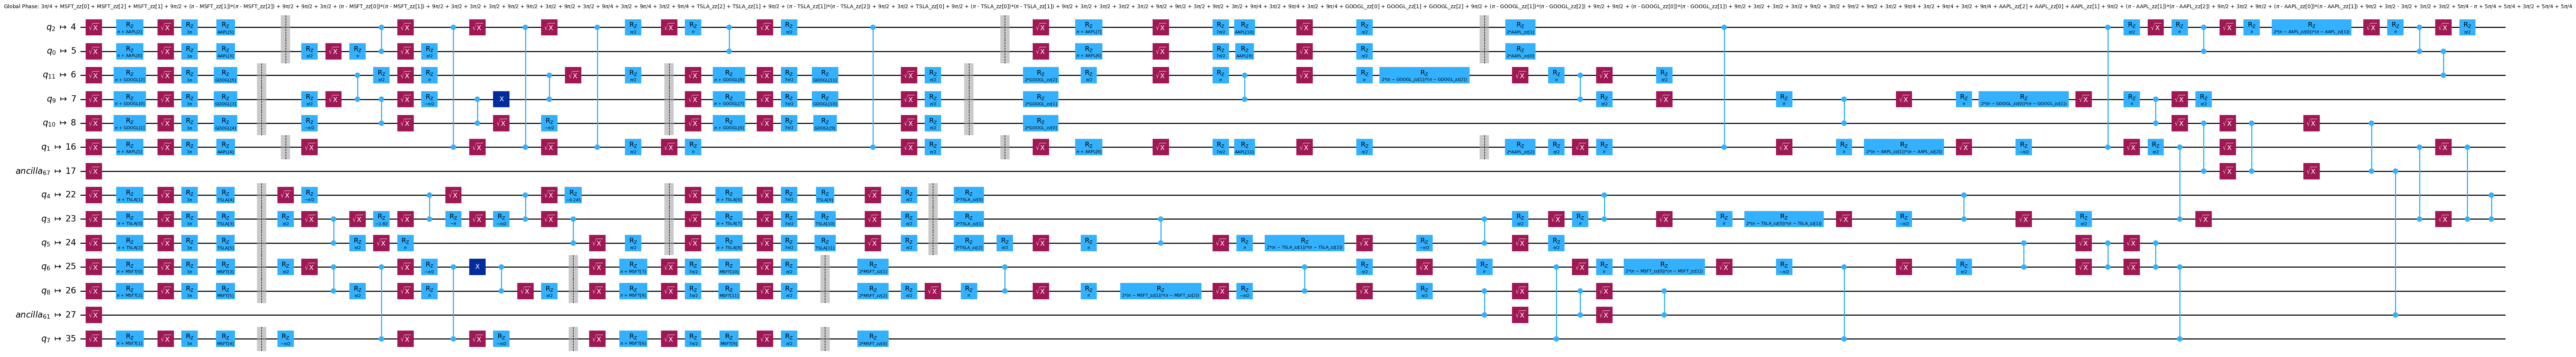

In [19]:

circuit , q_2 = optimise_circuit_best(qc, trials=10, backend=backend)
print(circuit.depth())
print(q_2)
circuit.draw('mpl', fold=-1)

In [20]:
from qiskit.quantum_info import SparsePauliOp
 
observable = [SparsePauliOp.from_list([(f"{'I'*i}Z{'I'*(num_qubits-i-1)}", 1)]) for i in range(num_qubits)]

In [21]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
 
 
def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.
 
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.
 
    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
 
    return expectation_values

In [22]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).
 
    prediction: predictions from the forward pass of neural network.
    target: true labels.
 
    output: MSE loss.
    """
    # Jayden please can you complete this function using GAN stuff (might not be MSE)

In [23]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.
 
    weight_params: ansatz parameters to be updated by the optimizer.
 
    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )
 
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
 
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1
 
    return cost

In [24]:
from scipy.optimize import minimize

In [25]:
# Globals
circuit = qc
observables = observable
# input_params = train_images_batch
# target = train_labels_batch
objective_func_vals = []
iter = 0

In [26]:
params = circuit.parameters

def split_parameters(params):
    """
    Splits Qiskit ParameterVectorElements into input params and weight params
    based on '_zz' suffix in their names.
    """
    input_params = []
    weight_params = []
    
    for p in params:
        if "_zz" in p.name:  # weight parameters
            weight_params.append(p)
        else:  # input/data parameters
            input_params.append(p)
    
    return input_params, weight_params


input_params, weight_params = split_parameters(params)

print(f"Input params: {input_params}")
print(f"Weight params: {weight_params}")


Input params: [ParameterVectorElement(AAPL[0]), ParameterVectorElement(AAPL[1]), ParameterVectorElement(AAPL[2]), ParameterVectorElement(AAPL[3]), ParameterVectorElement(AAPL[4]), ParameterVectorElement(AAPL[5]), ParameterVectorElement(AAPL[6]), ParameterVectorElement(AAPL[7]), ParameterVectorElement(AAPL[8]), ParameterVectorElement(AAPL[9]), ParameterVectorElement(AAPL[10]), ParameterVectorElement(AAPL[11]), ParameterVectorElement(GOOGL[0]), ParameterVectorElement(GOOGL[1]), ParameterVectorElement(GOOGL[2]), ParameterVectorElement(GOOGL[3]), ParameterVectorElement(GOOGL[4]), ParameterVectorElement(GOOGL[5]), ParameterVectorElement(GOOGL[6]), ParameterVectorElement(GOOGL[7]), ParameterVectorElement(GOOGL[8]), ParameterVectorElement(GOOGL[9]), ParameterVectorElement(GOOGL[10]), ParameterVectorElement(GOOGL[11]), ParameterVectorElement(MSFT[0]), ParameterVectorElement(MSFT[1]), ParameterVectorElement(MSFT[2]), ParameterVectorElement(MSFT[3]), ParameterVectorElement(MSFT[4]), ParameterVec